In [1]:
from typing import cast
import tensorflow as tf
import keras
import retina
import matplotlib.pyplot as plt

In [21]:
def transform_label(x, y):
  # Assumes 4 class names
  return x, (4 - y) / 4
def normalize_image(x, y):
  return (x / 255), y
def clamp_zero_one(x, y):
  return tf.maximum(tf.minimum(x, 1), 0), y

def apply_transformation(dataset: tf.data.Dataset):
  return dataset.map(transform_label).map(normalize_image)

In [3]:
training_dataset = apply_transformation(cast(tf.data.Dataset, keras.utils.image_dataset_from_directory(
  directory=retina.filesys.DATA_PATH,
  color_mode="grayscale",
  image_size=retina.size.FACE_DIMENSIONS.tuple,
  seed=42,
  validation_split=0.2,
  subset='training',
)))
validation_dataset = apply_transformation(cast(tf.data.Dataset, keras.utils.image_dataset_from_directory(
  directory=retina.filesys.DATA_PATH,
  color_mode="grayscale",
  image_size=retina.size.FACE_DIMENSIONS.tuple,
  seed=42,
  subset='validation',
  validation_split=0.3,
)))

Found 32 files belonging to 4 classes.
Using 26 files for training.
Found 32 files belonging to 4 classes.
Using 9 files for validation.


In [25]:
data_augmentation = keras.Sequential([
  keras.layers.RandomFlip("horizontal"),
  keras.layers.RandomRotation(0.05),
  keras.layers.RandomTranslation(0.1, 0.1),
  # keras.layers.RandomBrightness(0.1),
  # keras.layers.RandomContrast(0.1),
])

augmented_dataset = training_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

[[8.463893  8.502623  8.520949  ... 9.19707   9.195854  9.190088 ]
 [8.460975  8.497164  8.508362  ... 9.1964855 9.1950865 9.189207 ]
 [8.513198  8.594831  8.733588  ... 9.206937  9.208819  9.204969 ]
 ...
 [8.538102  8.659534  8.714675  ... 8.538972  8.538971  8.539019 ]
 [8.493391  8.564129  8.645774  ... 8.539395  8.541615  8.539104 ]
 [8.511385  8.521421  8.53908   ... 8.526414  8.529729  8.532674 ]]


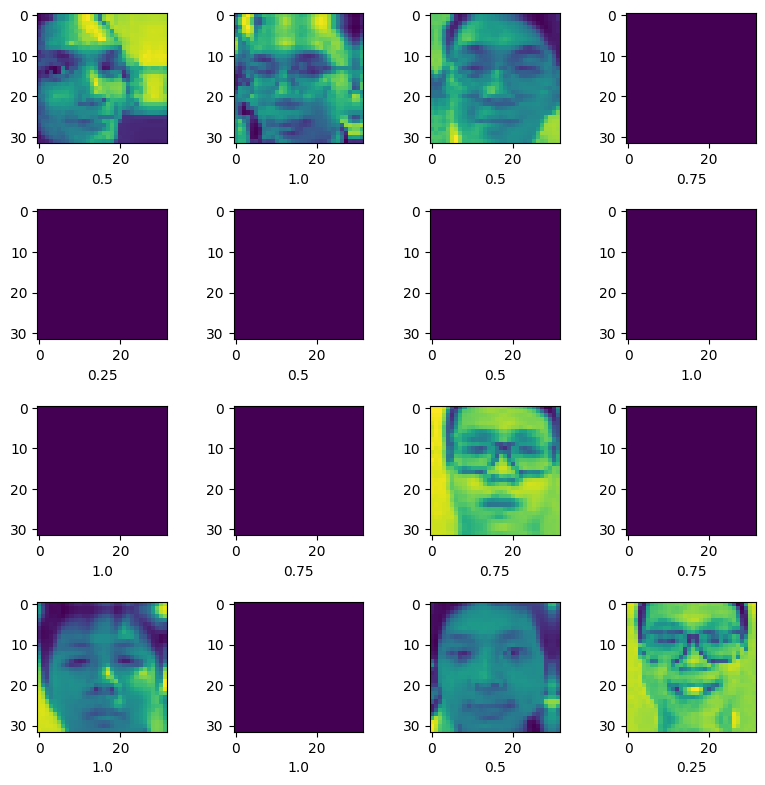

In [28]:
for batch, labels in augmented_dataset.take(1):
  images = list(tf.squeeze(batch).numpy())
  print(images[0])
  str_labels = list(map(str, labels.numpy()))
  subplots = retina.debug.collage_images_plt(images, str_labels, (4, 4))

In [6]:
model = keras.Sequential([
  keras.layers.Input(shape=retina.size.FACE_DIMENSIONS.tuple),
  keras.layers.Flatten(),
  keras.layers.Dense(128),
  keras.layers.Dense(128),
  keras.layers.Dense(1),
])

model.compile(
  optimizer=keras.optimizers.Adam(), # type: ignore
  loss=keras.losses.MeanSquaredError(),
  metrics=["accuracy"]
)

In [7]:
history = model.fit(augmented_dataset, epochs=10, validation_data=validation_dataset)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 2051.3450 - val_accuracy: 0.0000e+00 - val_loss: 25.2571
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step - accuracy: 0.1154 - loss: 56317.6289 - val_accuracy: 0.0000e+00 - val_loss: 0.2714
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.1538 - loss: 688.9698 - val_accuracy: 0.0000e+00 - val_loss: 18.3537
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.0000e+00 - loss: 19294.6953 - val_accuracy: 0.0000e+00 - val_loss: 26.6839
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.0000e+00 - loss: 54543.5195 - val_accuracy: 0.0000e+00 - val_loss: 10.7081
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.0000e+00 - loss: 9129.3857 - val_accuracy: 0.0000e+00 - val_loss: 1.5549
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.0000e+00 - loss: 727.9913 - val_accuracy: 0.0000e+00 - val_loss: 0.7718
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/st

C:\Users\Irsan\AppData\Local\Temp\ipykernel_13600\469801421.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  accuracy_fig.show()


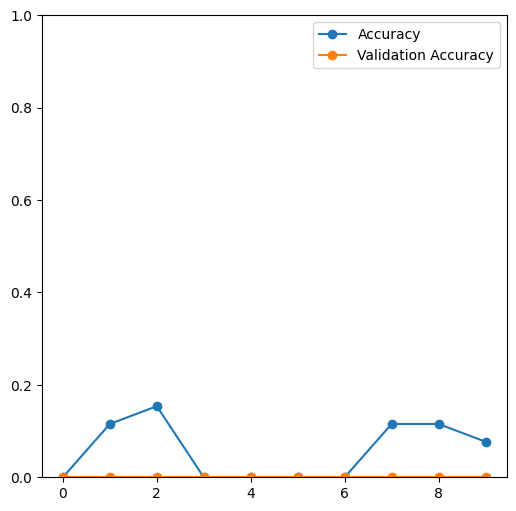

In [8]:
accuracy_fig = plt.figure(figsize=(6,6))
ax = accuracy_fig.add_subplot()
ax.plot(history.history["accuracy"], label="Accuracy", marker='o')
ax.plot(history.history["val_accuracy"], label="Validation Accuracy", marker='o')
ax.legend()
ax.set_ylim(0, 1)
accuracy_fig.show()